# Exemplo de pré processamento e extração de características

In [256]:
from pathlib import Path
from random import choice
from numpy import ones, pi
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_holes, remove_small_objects, closing
from skimage.feature import canny, corner_harris, corner_peaks
from skimage.measure import label, regionprops, find_contours, approximate_polygon, perimeter_crofton
from skimage.util import img_as_float

def plot_image(image,title="Image"):
    fig, axes = plt.subplots(1, 1, figsize=(15, 3))
    if len(image.shape)>2:
        axes.imshow(image)
    else:
        axes.imshow(image,cmap=plt.cm.gray)
    axes.set_title(title)
    axes.axis('off')
    plt.tight_layout()
    plt.show()

Carregando uma imagem do dataset Flavia Leaf

Imagens encontradas na pasta Leaves: 1907
Imagem selecionada aleatoriamente: Leaves/1083.jpg


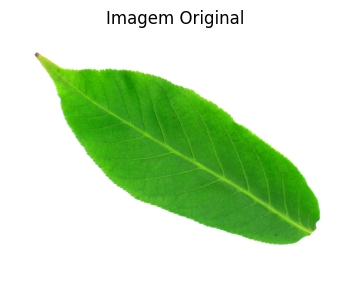

In [257]:
dataset_dir = Path(r"Leaves")
img_files = []

if dataset_dir.is_dir():
    img_files = sorted([file for file in dataset_dir.glob("*.jpg")])
else:
    print("Pasta Leaves não foi localizada. Faça o download do dataset e extraia dentro do diretório atual.")

if len(img_files) > 0:
    print(f"Imagens encontradas na pasta Leaves: {len(img_files)}")
    img_name =  choice(img_files)
    print(f"Imagem selecionada aleatoriamente: {img_name}") 
    img = imread(img_name)
    plot_image(img,"Imagem Original")
else:
    img = None
    print("Nenhuma imagem .jpg foi encontrada na pasta Leaves. Verifique se o dataset foi extraído corretamente")

# Etapas de pré-processamento 



Primeira Etapa: Conversão de RBG para Tons de Cinza

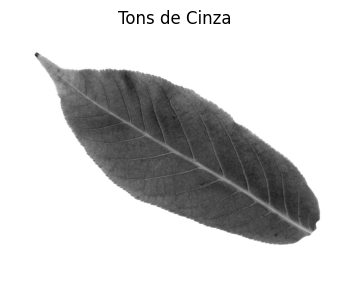

In [258]:
if img is not None:
    img_gray = img_as_float(rgb2gray(img))
    plot_image(img_gray,"Tons de Cinza")
else:
    img_gray = None
    print("Imagem Original não foi carregada corretamente.")

Segunda Etapa: Aplicação do filtro Gaussiano

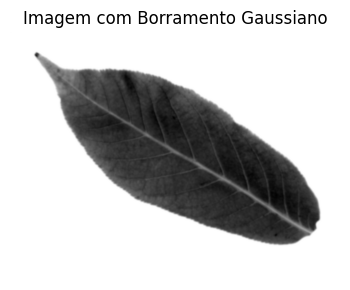

In [259]:
if img_gray is not None:
    img_blur = gaussian(img_gray,sigma=3.0)
    plot_image(img_blur,"Imagem com Borramento Gaussiano")
else:
    img_blur = None
    print("Imagem Original não foi carregada corretamente.")

Terceira Etapa: Binarização com Limiar Otsu

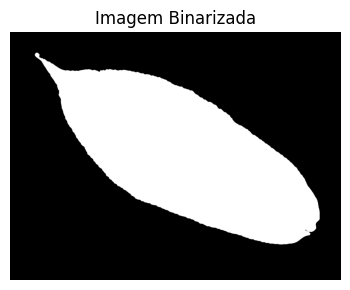

In [260]:
if img_blur is not None:
    limiar = threshold_otsu(img_blur)
    img_bin = img_blur < limiar
    plot_image(img_bin,"Imagem Binarizada")
else:
    img_bin = None
    print("Imagem Original não foi carregada corretamente.")

Quinta Etapa: Fechamento Morfológico

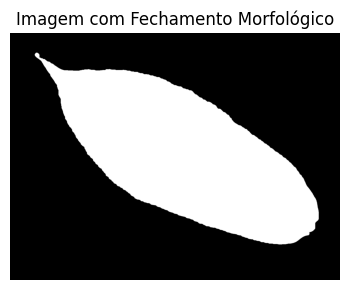

In [261]:
if img_bin is not None:
    img_closing = closing(img_bin,ones((20,20)))
    img_closing = remove_small_holes(img_closing,area_threshold=5000,connectivity=1)
    img_closing = remove_small_objects(img_closing,min_size=1000)
    plot_image(img_closing,"Imagem com Fechamento Morfológico")
else:
    img_closing =  None
    print("Imagem Original não foi carregada corretamente.")

# Extração de características

Arquivo: Leaves/1083.jpg
Id Objeto: 1
Área: 626869.0
Perímetro: 3828.200502512498
Eixo Maior: 1442.227256658988
Eixo Menor: 557.8701339738109
Excentricidade: 0.9221587927626066
Circularidade: 0.5375233141166117
Compacidade: 23.37828013099538
Alongamento: 2.5852383356422752
Solidez: 0.9586662731286426
Redondeza: 0.38372448699403183
Cantos: 1


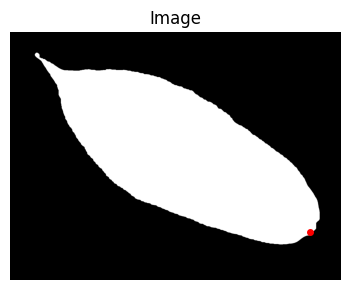

In [262]:
def count_corners(img,sensitivity=0.04,sigma=1.0):
    img = img_as_float(img)
    harris_response = corner_harris(img,k=sensitivity,sigma=sigma)
    corner_coords = corner_peaks(harris_response,min_distance=60,threshold_rel=0.05)
    return len(corner_coords), corner_coords

features = {
    "Arquivo": img_name,
    "Id Objeto": None,
    "Região Objeto": None,
    "Área": 0.0,
    "Perímetro": 0.0,
    "Eixo Maior": 0.0,
    "Eixo Menor": 0.0,
    "Excentricidade": 0.0,
    "Circularidade": 0.0,
    "Compacidade": 0.0,
    "Alongamento": 0.0,
    "Solidez": 0.0,
    "Redondeza": 0.0,
    "Cantos": 0,
    "Coordenadas Cantos": None
}

if img_closing is not None:
    img_label = label(img_closing,connectivity=2)
    img_props = regionprops(img_label)
    for label_id, img_prop in enumerate(img_props,start=1):
        roi_id = label_id
        roi = img_prop.image
        area = img_prop.area
        perimeter = img_prop.perimeter
        axis_major = img_prop.axis_major_length
        axis_minor = img_prop.axis_minor_length
        eccentricity = img_prop.eccentricity
        solidity = img_prop.solidity

        circularity = 0.0
        if  perimeter != 0: circularity = (4*pi*area)/(perimeter**2)

        compacidade = 0.0
        if area != 0: compacidade = (perimeter**2)/area

        alongamento = 0.0
        if axis_minor != 0: alongamento = axis_major/axis_minor 

        redondeza = 0.0
        if axis_major != 0: redondeza = (4*area)/(pi*(axis_major**2))

        corners,corners_coords = count_corners(img_closing,sensitivity=0.2,sigma=1.0)

        features["Id Objeto"]=roi_id
        features["Região Objeto"]=roi
        features["Área"]=area
        features["Perímetro"]=perimeter
        features["Eixo Maior"]=axis_major
        features["Eixo Menor"]=axis_minor
        features["Excentricidade"]=eccentricity
        features["Solidez"]=solidity
        features["Circularidade"]=circularity
        features["Compacidade"]=compacidade
        features["Alongamento"]=alongamento
        features["Redondeza"]=redondeza
        features["Cantos"]=corners
        features["Coordenadas Cantos"]=corners_coords

    for key, value in features.items():
        if key != "Coordenadas Cantos" and key != "Região Objeto":
            print(f"{key}: {value}")

    fig, axes = plt.subplots(1, 1, figsize=(15, 3))
    coords_y = features["Coordenadas Cantos"][:, 0]
    coords_x = features["Coordenadas Cantos"][:, 1]
    fig.canvas.manager.set_window_title("Image")
    axes.imshow(img_closing,cmap=plt.cm.gray)
    axes.plot(coords_x, coords_y, 'ro', markersize=4)
    axes.set_title("Image")
    axes.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Falha no pré processamento da imagem. Não foi possível extrair características.")